In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("electronic_components.csv", encoding="big5")

data.columns = [
    'code', 'name', 'industry_code', 'industry', 'date', 'price'
]

data.head()

,code,name,industry_code,industry,date,price
0,1471,首利,M23D,電子零組件,2000/01/04W2,8.98
1,2308,台達電,M23D,電子零組件,2000/01/04W2,25.32
2,2313,華通,M23B,主機板,2000/01/04W2,83.64
3,2316,楠梓電,M23B,主機板,2000/01/04W2,27.89
4,2327,國巨,M23D,電子零組件,2000/01/04W2,55.14


### 檢視TEJ產業分布，電子零組件為公司家數最高的公司，先選此類別為標的選擇pool

In [3]:
test = data[data.date ==  "2019/06/14W5"]
test.groupby("industry").count()

,code,name,industry_code,date,price
industry,,,,,
主機板,28,28,28,28,28
光電/ IO,4,4,4,4,4
汽車組件,1,1,1,1,1
消費性電子,1,1,1,1,1
資訊通路,1,1,1,1,1
金屬製品,1,1,1,1,1
電子設備,2,2,2,2,2
電子零組件,58,58,58,58,58


In [4]:
ec_data = data[data["industry"] == "電子零組件"]
ec_data = ec_data.copy()

ec_data.loc[:, "date"] = list(map(
    lambda x: datetime.strptime(x.split("W")[0], "%Y/%m/%d"),
    ec_data["date"].values
))

ec_data.head()

,code,name,industry_code,industry,date,price
0,1471,首利,M23D,電子零組件,2000-01-04,8.98
1,2308,台達電,M23D,電子零組件,2000-01-04,25.32
4,2327,國巨,M23D,電子零組件,2000-01-04,55.14
5,2328,廣宇,M23D,電子零組件,2000-01-04,17.59
9,2375,智寶,M23D,電子零組件,2000-01-04,46.39


# 以1471, 2328為例子

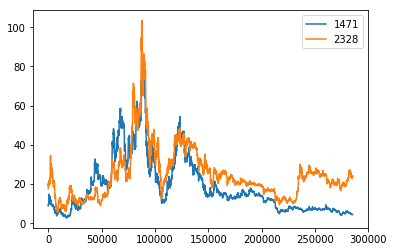

In [5]:
plt.plot(ec_data[ec_data.code == 1471]["price"], label='1471')
plt.plot(ec_data[ec_data.code == 2328]["price"], label='2328')
plt.legend();

In [6]:
stock_1 = ec_data[ec_data.code == 1471][["price", "date"]]
stock_2 = ec_data[ec_data.code == 2328][["price", "date"]]

pairs = stock_1.merge(stock_2, on="date", suffixes=('_1', '_2'))
pairs["year"] = pairs["date"].apply(lambda x: x.year)
pairs["month"] = pairs["date"].apply(lambda x: x.month)
temp_pairs = pairs[pairs.year == 2000]

## 步驟
* 首先檢定價格序列本身是否為I(1)

  →先看序列本身是否為非定態，取差分後又是否為定態

* 確定兩序列皆為I(1)後，透過迴歸模型fit出一條線，接著看其residual是否為I(0)，若是則代表共整合存在

## 檢定價格序列

In [7]:
from arch.unitroot import ADF

def ADF_test_price(price, alpha=0.05):
    adf_price = ADF(np.log(price))
    adf_return = ADF(np.log(price).diff()[1:])
    adf_price_is_pass = adf_price.pvalue < alpha
    adf_return_is_pass = adf_return.pvalue < alpha
    if (adf_price_is_pass == False) and (adf_return_is_pass == True):
        is_I1 = True
    else:
        is_I1 = False
        
    result = pd.DataFrame([[
        adf_price.pvalue, adf_price_is_pass, adf_return.pvalue, adf_return_is_pass, is_I1
    ]],
    columns=[
        'adf_price_pvalue', 'adf_price_is_pass', 'adf_return_pvalue', 'adf_return_is_pass', 'is_I1'
    ])
    
    return result

C:\Users\andy5\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [8]:
ADF_test_price(temp_pairs["price_1"])

,adf_price_pvalue,adf_price_is_pass,adf_return_pvalue,adf_return_is_pass,is_I1
0,0.779125,False,3.002042e-10,True,True


In [9]:
ADF_test_price(temp_pairs['price_2'])

,adf_price_pvalue,adf_price_is_pass,adf_return_pvalue,adf_return_is_pass,is_I1
0,0.995866,False,0.00007,True,True


## 建迴歸模型並檢定spread(以下將比較OLS與TLS的差異)

![difference](https://i.imgur.com/d0tYpjV.png)

### OLS模型

In [10]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

def run_regression(x, y):
    X = add_constant(x)
    Y = y
    model = OLS(Y, X, missing="drop")
    result = model.fit()
    return result

In [11]:
model_1 = run_regression(np.log(temp_pairs["price_1"]), np.log(temp_pairs["price_2"]))
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                price_2   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     450.7
Date:                Thu, 27 Jun 2019   Prob (F-statistic):           2.00e-59
Time:                        15:33:23   Log-Likelihood:                -54.795
No. Observations:                 271   AIC:                             113.6
Df Residuals:                     269   BIC:                             120.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3088      0.120      2.565      0.0

In [12]:
# 發現residual非定態(殘差均值為0將trend設為nc)
ADF(model_1.resid, trend="nc")

Test Statistic,-1.281
P-value,0.185
Lags,7


In [13]:
model_2 = run_regression(np.log(temp_pairs["price_2"]), np.log(temp_pairs["price_1"]))
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                price_1   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     450.7
Date:                Thu, 27 Jun 2019   Prob (F-statistic):           2.00e-59
Time:                        15:33:23   Log-Likelihood:                 57.930
No. Observations:                 271   AIC:                            -111.9
Df Residuals:                     269   BIC:                            -104.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6260      0.071      8.850      0.0

In [14]:
# 發現residual為定態(殘差均值為0將trend設為nc)
ADF(model_2.resid, trend="nc")

Test Statistic,-2.151
P-value,0.030
Lags,7


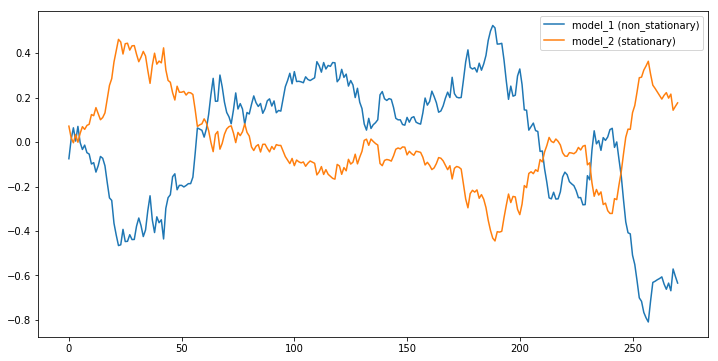

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(model_1.resid, label="model_1 (non_stationary)")
plt.plot(model_2.resid, label="model_2 (stationary)")
plt.legend();

以上觀察可以發現(不用OLS的原因)：
* 由上可以發現交換放x, y時，殘差是否為定態的p value竟然可以由顯著轉為不顯著，感覺不太solid
* 交換放x, y時，作為long short比例的Beta係數會有差異(1.1995 vs 0.5221)，0.5221取倒數為1.9157可以發現比例差異很大。由於用TLS即使在交換x, y位置下，beta係數互為倒數，因此可以固定作為long short比例的Beta值(paper上看到的)→所以將選擇TLS模型

## TLS模型

In [16]:
from scipy import odr

def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

In [17]:
linear = odr.Model(f)

used_data = odr.Data(np.log(temp_pairs['price_1']),
                     np.log(temp_pairs['price_2']))

odr_model_1 = odr.ODR(used_data, linear, beta0=[1., 2.])

result_1 = odr_model_1.run()

result_1.pprint()

Beta: [ 1.67783217 -0.69851984]
Beta Std Error: [ 0.07155313  0.15206033]
Beta Covariance: [[ 0.17451813 -0.36754809]
 [-0.36754809  0.78816141]]
Residual Variance: 0.02933706681145965
Inverse Condition #: 0.04464581898217315
Reason(s) for Halting:
  Sum of squares convergence


In [18]:
spread_1 =(
    np.log(temp_pairs['price_2']) -
    result_1.beta[1] -
    result_1.beta[0]*np.log(temp_pairs["price_1"])
)

In [19]:
ADF(spread_1, trend="nc")

Test Statistic,-2.045
P-value,0.039
Lags,7


In [20]:
used_data = odr.Data(np.log(temp_pairs['price_2']),
                     np.log(temp_pairs['price_1']))

odr_model_2 = odr.ODR(used_data, linear, beta0=[1., 2.])

result_2 = odr_model_2.run()

result_2.pprint()

Beta: [ 0.59599691  0.41635192]
Beta Std Error: [ 0.02541722  0.0730717 ]
Beta Covariance: [[ 0.02202112 -0.06243249]
 [-0.06243249  0.18200433]]
Residual Variance: 0.029337066814775818
Inverse Condition #: 0.04469181070659225
Reason(s) for Halting:
  Sum of squares convergence


In [21]:
spread_2 =(
    np.log(temp_pairs['price_1']) -
    result_2.beta[1] -
    result_2.beta[0]*np.log(temp_pairs["price_2"])
)

In [22]:
ADF(spread_2, trend="nc")

Test Statistic,-2.045
P-value,0.039
Lags,7


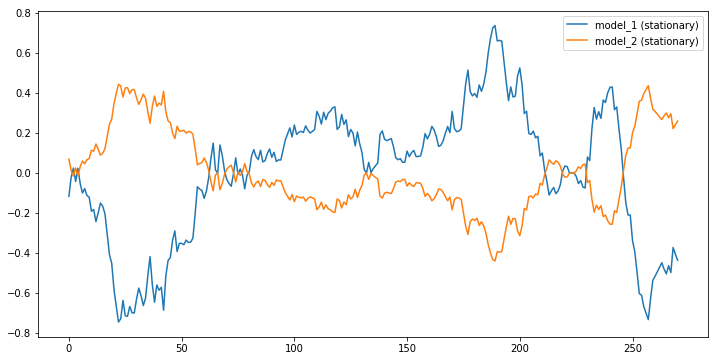

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(spread_1, label="model_1 (stationary)")
plt.plot(spread_2, label="model_2 (stationary)")
plt.legend();

以上觀察可以發現：
* 由上可以發現使用TLS模型時交換放x, y，殘差是否為定態的p value皆為顯著
* 可以發現Beta係數為1.67783217 vs 0.59599691，其中0.59599691的倒數為1.6778610，可以發現x, y互換時beta值的確為倒數，因此long short比例固定

## 交易範例
(使用TLS中的第一個模型)

In [24]:
std_threshold = 2
spread_upper_band = np.std(spread_1)*std_threshold
spread_lower_band = -np.std(spread_1)*std_threshold

### 模型估計出的參數使用資料為2000年的日資料，因此接下來檢視模型未看過的2001年20001資料

In [25]:
unseen_pairs = pairs[(pairs.year == 2001) | (pairs.year == 2002)]

spread_new =(
    np.log(unseen_pairs['price_2']) -
    result_1.beta[1] -
    result_1.beta[0]*np.log(unseen_pairs["price_1"])
)

In [26]:
unseen_pairs = unseen_pairs.copy()
unseen_pairs.loc[:, 'spread'] = spread_new
unseen_pairs.head()

,price_1,date,price_2,year,month,spread
271,4.90,2001-01-02,5.87,2001,1,-0.198095
272,4.62,2001-01-03,6.13,2001,1,-0.056031
273,4.89,2001-01-04,6.55,2001,1,-0.085057
274,5.18,2001-01-05,7.00,2001,1,-0.115277
275,5.50,2001-01-08,7.08,2001,1,-0.204487


In [27]:
stock_1 = unseen_pairs[['price_1', 'date', 'spread']]
stock_1 = stock_1.copy()
stock_1.rename(columns={'price_1': 'close'}, inplace=True)
stock_1['spread_upper_band'] = spread_upper_band
stock_1['spread_lower_band'] = spread_lower_band

stock_2 = unseen_pairs[['price_2', 'date', 'spread']]
stock_2 = stock_2.copy()
stock_2.rename(columns={'price_2': 'close'}, inplace=True)

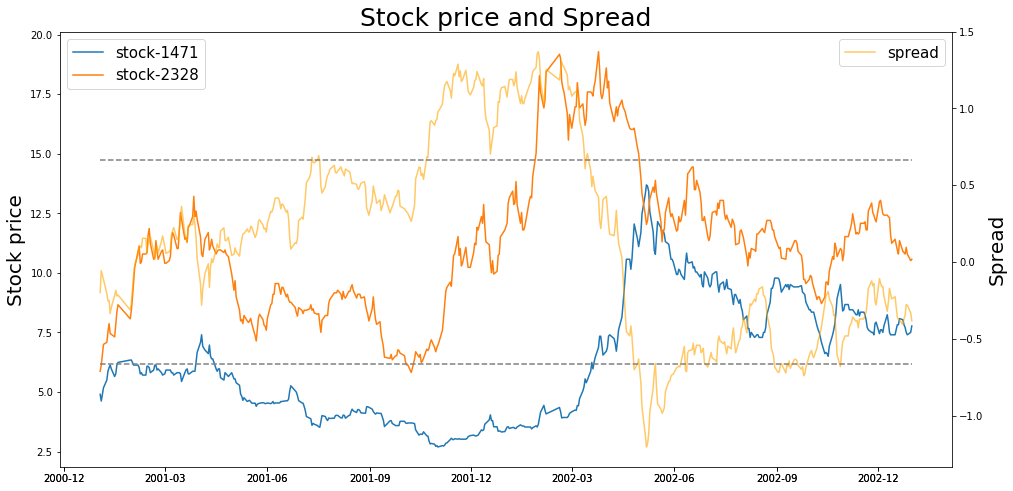

In [28]:
time_index = pd.to_datetime(unseen_pairs.date)
fig = plt.figure(figsize = (16, 8))

ax1 = fig.add_subplot(111)
ax1.plot(time_index,
         unseen_pairs.price_1, label="stock-1471")
ax1.plot(time_index,
         unseen_pairs.price_2, label="stock-2328")
ax1.legend(fontsize=15, loc="upper left")
plt.ylabel("Stock price", fontsize = 20)

ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
plt.sca(ax2)
plt.grid(False)
ax2.plot(time_index,
         spread_new.values, c='orange', alpha=0.6, label="spread")
ax2.plot(time_index,
         [spread_upper_band]*len(spread_new), c="grey", ls="--")
ax2.plot(time_index,
         [spread_lower_band]*len(spread_new), c="grey", ls="--")
ax2.legend(fontsize=15, loc="upper right")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
plt.ylabel("Spread", fontsize = 20)

plt.title("Stock price and Spread", fontsize=25);

In [29]:
from pair_trading.basic_tool import preprocess, crossover, crossunder
from pair_trading.strategy import Strategy
from pair_trading.analysis import Analysis

In [30]:
stock_1, stock_2 = preprocess(stock_1, stock_2)

condition_in = [
    crossover(stock_1.spread, stock_1.spread_upper_band)
]

condition_out = [
    stock_1.spread < -2*np.std(spread_1)
]

strategy = Strategy(
    # 訊號出現後何時進出場，0為出現後馬上執行交易，1為下一個價格執行交易，2...以此類推
    next_bar=1,
    # 以甚麼價格進行交易
    trade_on='close',
    # 初始資金(後續分析中沒有使用到)
    initial_capital=1000000,
    # 交易稅
    tax_rate=0.003,
    # 交易成本(率)
    cost=0.001425
)

strategy.run(
    # condition_in成立時欲做多的股票
    stock_1,
    # condition_in成立時欲放空的股票
    stock_2,
    # 進場訊號
    condition_in,
    # 出場訊號
    condition_out,
    # 對沖比率，預設為auto，亦即將兩兩欲交易的價格(trade_on)進行比較，
    # 將價格較高者部位設為1，價格較低者部位則由高價除以低價並四捨五入
    # 也可以輸入list如：[2, 1]，將會以2:1的部位進行交易(stock_to_buy : stock_to_sellshort)
    hedge_ratio=[result_1.beta[0], 1]
)

strategy_analysis = Analysis(
    # 欲分析的策略
    strategy
)

# 進行分析
strategy_analysis.run()

# 策略績效基本資訊
strategy_analysis.summary(
    # 檢視策略績效總結果，另有'buy'(做多交易), 'sellshort'(放空交易)
    select_result='total'
)

,total_profit,average_return,winning_rate,max_drowdown,average_holding_days,total_trade_number
0,6056.6406,1.2822,1.0,0.0,291.0,1


In [31]:
strategy_analysis.total_trade_result

,net_profit,net_return,holding_date,maximum_favorable_excursion,maximum_adverse_excursion
0,6056.640623,1.282161,291.0,16540.45321,-12624.055886


In [32]:
strategy_analysis.stock_to_buy_trade_table[
    (strategy_analysis.stock_to_buy_trade_table.entry_exit_points >0) |
    (strategy_analysis.stock_to_buy_trade_table.entry_exit_points <0)
]

,date,close_price,holdings,entry_exit_points,cash,total_value,cumulative_profit
127,2001-07-12,3.68,6174.42238,1677.832168,9.938256e+05,1.000000e+06,0.000000
318,2002-04-29,11.41,0.00000,-1677.832168,1.012970e+06,1.012970e+06,12969.642662


In [33]:
condition_in = [
    crossunder(stock_1.spread, stock_1.spread_lower_band)
]

condition_out = [
    stock_1.spread > 2*np.std(spread_1)
]

strategy = Strategy(
    # 訊號出現後何時進出場，0為出現後馬上執行交易，1為下一個價格執行交易，2...以此類推
    next_bar=1,
    # 以甚麼價格進行交易
    trade_on='close',
    # 初始資金(後續分析中沒有使用到)
    initial_capital=1000000,
    # 交易稅
    tax_rate=0.003,
    # 交易成本(率)
    cost=0.001425
)

strategy.run(
    # condition_in成立時欲做多的股票
    stock_2,
    # condition_in成立時欲放空的股票
    stock_1,
    # 進場訊號
    condition_in,
    # 出場訊號
    condition_out,
    # 對沖比率，預設為auto，亦即將兩兩欲交易的價格(trade_on)進行比較，
    # 將價格較高者部位設為1，價格較低者部位則由高價除以低價並四捨五入
    # 也可以輸入list如：[2, 1]，將會以2:1的部位進行交易(stock_to_buy : stock_to_sellshort)
    hedge_ratio=[1, result_1.beta[0]]
)

strategy_analysis = Analysis(
    # 欲分析的策略
    strategy
)

# 進行分析
strategy_analysis.run()

# 策略績效基本資訊
strategy_analysis.summary(
    # 檢視策略績效總結果，另有'buy'(做多交易), 'sellshort'(放空交易)
    select_result='total'
)

,total_profit,average_return,winning_rate,max_drowdown,average_holding_days,total_trade_number
0,1293.8662,0.0041,1.0,0.0,246.0,1


In [34]:
strategy_analysis.total_trade_result

,net_profit,net_return,holding_date,maximum_favorable_excursion,maximum_adverse_excursion
0,1293.866155,0.004109,246.0,8084.713009,-10498.900282


In [35]:
strategy_analysis.stock_to_buy_trade_table[
    (strategy_analysis.stock_to_buy_trade_table.entry_exit_points >0) |
    (strategy_analysis.stock_to_buy_trade_table.entry_exit_points <0)
]

,date,close_price,holdings,entry_exit_points,cash,total_value,cumulative_profit
318,2002-04-29,15.23,15230.0,1000.0,984770.0,1000000.0,0.0
491,2002-12-31,10.57,0.0,-1000.0,995340.0,995340.0,-4660.0


# Reference
* [Total Least Squares in comparison with OLS and ODR](https://towardsdatascience.com/total-least-squares-in-comparison-with-ols-and-odr-f050ffc1a86a)

* [Orthogonal distance regression (scipy.odr)](https://docs.scipy.org/doc/scipy/reference/odr.html)